In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchcam.methods import GradCAM
import RNA
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('p04_clinvar_with_latent.csv')

In [9]:
df

,spacer,spacer_length,scaffold,target,editing_position,Eff,sec_struc,dot_bracket,feature_0,feature_1,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,CAGATGGGGCTCCTGGATCA,20,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,CAACTGTGTCGGAAGGTCAAGTTCCAGGTGGACTTCAACCTGATCA...,-25,0.0,CAGATGGGGCTCCTGGATCAGTCATAGTTCCATTAAAGCCAAAAGT...,.((((((((...........(((((((...(((((((((((....)...,0.678111,0.890779,...,4.732837,2.880480,3.113352,0.0,1.462264,4.067187,0.0,3.041834,3.309018,6.192444
1,ATGTTTGCACCCATCCTGGAT,21,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,AAGAACCGCAGGGCTGTGCTTGCCCTGGAGCACATGTTTGCACCCA...,-25,0.0,ATGTTTGCACCCATCCTGGATGTCATAGTTCCATTAAAGCCAAAAG...,.......((((((...))).((((((((...(((((((((((.......,0.632554,0.853390,...,4.732837,2.531475,3.113352,0.0,1.872994,4.129654,0.0,3.041834,3.342679,6.192444
2,TGATTTTGTTGGAGGCCATTCCCC,24,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,TATGTCTACAACCTACACTTGGTTGAAAATGATTTTGTTGGAGGCC...,-25,0.0,TGATTTTGTTGGAGGCCATTCCCCGTCATAGTTCCATTAAAGCCAA...,...........((.(((((.....(((((((...(((((((((((....,0.656517,0.827227,...,4.732837,2.675503,3.113352,0.0,2.141624,4.067187,0.0,3.041834,3.342679,6.192444
3,GCAAATGTCCTCCCAGATTTACCC,24,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,CTATGTGTTAACACCATTGGCGGCTTCACATGCAAATGTCCTCCCA...,-25,0.0,GCAAATGTCCTCCCAGATTTACCCGTCATAGTTCCATTAAAGCCAA...,....((((((.....((...(((((((((((...(((((((((((....,0.615091,0.847944,...,4.732837,2.531475,3.113352,0.0,1.781262,4.067187,0.0,3.041834,3.130317,6.192444
4,CCGTGGCCATGCTTCCTCTCAC,22,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,AGGCTACGCCTGTCCCCCAGCCCTACCTCGCAGCGCAGCCGTGGCC...,-25,0.0,CCGTGGCCATGCTTCCTCTCACGTCATAGTTCCATTAAAGCCAAAA...,.....((((((..((..(((..(((((((...(((((((((((......,0.609239,0.833170,...,4.732837,2.531475,3.113352,0.0,3.053181,4.108424,0.0,3.041834,3.130317,6.192444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261070,CTGAACGTCCCCCACTTTCTCATGT,25,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,GTCCTGCTTATTCTCCTCACCAGCCACTACAAACTGAACGTCCCCC...,-1,0.0,CTGAACGTCCCCCACTTTCTCATGTGTCATAGTTCCATTAAAGCCA...,....(((....((((.........((((((((...(((((((((((...,0.658569,0.787549,...,4.732837,2.531475,3.113352,0.0,1.898645,4.067187,0.0,3.041834,3.342679,6.192444
261071,GCTACTTGGTGCCTGGGCAGCGGG,24,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,CTGCACTACTCAGAGCGTCATGGCTGGGGCTACTTGGTGCCTGGGC...,-1,0.0,GCTACTTGGTGCCTGGGCAGCGGGGTCATAGTTCCATTAAAGCCAA...,((((((((.(((....))).))).(((((((...(((((((((((....,0.603041,0.910463,...,4.732837,2.531475,3.113352,0.0,2.413592,4.161389,0.0,3.041834,3.342679,6.192444
261072,TCCTGACCCCTGTCATCTTCTGTC,24,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,GCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCT...,-1,0.0,TCCTGACCCCTGTCATCTTCTGTCGTCATAGTTCCATTAAAGCCAA...,....((((((.(((.....((.(.(((((((...(((((((((((....,0.593780,0.832284,...,4.732837,2.675503,3.113352,0.0,2.700315,4.545311,0.0,3.041834,3.185388,6.192444
261073,TGCCTGAAGCTGTGCCCCTGTTCC,24,GTCATAGTTCCATTAAAGCCAAAAGTGGCTTTGATGTTTCTATGAT...,ACAGGGGCCTCGCTGGTCCTGCAGGTGTCCTACACACCGCTGCCTG...,-1,0.0,TGCCTGAAGCTGTGCCCCTGTTCCGTCATAGTTCCATTAAAGCCAA...,.(((......((...((((.....(((((((...(((((((((((....,0.634595,0.834115,...,4.732837,2.531475,3.113352,0.0,1.492253,4.588783,0.0,3.041834,3.130317,6.192444


In [37]:
df['target'][0]

'CAACTGTGTCGGAAGGTCAAGTTCCAGGTGGACTTCAACCTGATCAGATGGGGCTCCTGGATCATCTACCCCAAGCAGTACAACGCCTATCGC'

## preparing the latent features

In [4]:
latent_features_tensor = torch.tensor(df.loc[:, df.columns.str.startswith('feature')].values).float()

print("Latent Features Shape:", latent_features_tensor.shape)


Latent Features Shape: torch.Size([261075, 64])


## preparing other features

In [5]:
## Prepare inputs

dct_onehot = {'A': [1, 0, 0, 0],
              'C': [0, 1, 0, 0],
              'G': [0, 0, 1, 0],
              'T': [0, 0, 0, 1],
              'N': [0, 0, 0, 0]}

list_input1 = []

def pad_sequence(seq, target_length=100):
    return seq + [dct_onehot['N']] * (target_length - len(seq))



for idx in df.index:
    lst = []
    gd = df.loc[idx, 'spacer'].upper()
    tg = df.loc[idx, 'target'].upper()

    ## Target - pad after encoding
    encoded_tg = [dct_onehot[i] for i in tg]
    encoded_tg_padded = pad_sequence(encoded_tg)
    lst.append(encoded_tg_padded)

    ## Spacer - modify and then pad
    lst_tg = list(tg)
    st = tg.index(gd)
    sp = st + len(gd)
    for i in range(0, st):
        lst_tg[i] = 'N'
    for i in range(sp, len(lst_tg)):
        lst_tg[i] = 'N'
    encoded_spacer = [dct_onehot[i] for i in lst_tg]
    encoded_spacer_padded = pad_sequence(encoded_spacer)
    lst.append(encoded_spacer_padded)

    ## Editing region - modify and then pad
    lst_tg = list(tg)
    pos = df.loc[idx, 'editing_position']
    st1 = max(0, int(pos + st - 3))  # Ensure index is within bounds
    sp1 = min(len(lst_tg), int(pos + sp + 4))  # Ensure index is within bounds
    for i in range(0, st1):
        lst_tg[i] = 'N'
    for i in range(sp1, len(lst_tg)):
        lst_tg[i] = 'N'
    encoded_editing_region = [dct_onehot[i] for i in lst_tg]
    encoded_editing_region_padded = pad_sequence(encoded_editing_region)
    lst.append(encoded_editing_region_padded)

    ## C-region + PAM - modify and then pad
    lst_tg = list(tg)
    for i in range(0, len(lst_tg) - 16):
        lst_tg[i] = 'N'
    encoded_c_region_pam = [dct_onehot[i] for i in lst_tg]
    encoded_c_region_pam_padded = pad_sequence(encoded_c_region_pam)
    lst.append(encoded_c_region_pam_padded)

    ## Convert list of lists into a tensor
    a = np.array(lst, dtype=np.float32)
    t = torch.from_numpy(a)
    list_input1.append(t)

input_data1 = torch.stack(list_input1, dim=0)

input_data2 = latent_features_tensor
input_label = torch.Tensor([[i] for i in df.Eff.to_list()])

In [6]:
input_data1.shape

torch.Size([261075, 4, 100, 4])

In [7]:
input_data2 = latent_features_tensor

input_data2.shape

torch.Size([261075, 64])

In [16]:
class TwoBranchCNNRegressor(nn.Module):
    def __init__(self, input_channels1, input_dim2, output_size):
        super(TwoBranchCNNRegressor, self).__init__()

        # Adjusted Branch 1: Convolutional layers for 2D input
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels1, out_channels=32, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Dropout(0.5)
        )

        # Branch 2 remains the same
        self.branch2 = nn.Sequential(
            nn.Linear(input_dim2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Initialize dummy input to calculate sizes
        dummy_input1 = torch.randn(1, input_channels1, 100, 4)
        output1_size = self.branch1(dummy_input1).nelement()

        # The total input size for the final fully connected layer
        self.fc_input_size = output1_size + 256
        self.fc = nn.Linear(self.fc_input_size, 64)
        self.output_layer = nn.Linear(64, output_size)

    def forward(self, x1, x2):
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        
        # Flatten the outputs from both branches
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate the outputs from both branches
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        output = self.output_layer(x)
        
        return output


In [9]:
import torch
from torch.utils.data import Dataset

class InputDataset(Dataset):
    def __init__(self, input1, input2, labels):

        self.input1 = input1
        self.input2 = input2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ensure each sample is returned as a dictionary
        sample = {
            'input1': self.input1[idx],
            'input2': self.input2[idx],
            'label': self.labels[idx]
        }
        return sample


In [10]:
dataset = InputDataset(input_data1, input_data2, input_label)

In [11]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import KFold

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Assuming input1, input2, and labels are already tensors loaded and prepared
for fold, (train_index, val_index) in enumerate(kf.split(input_label)):
    print(f"\nFold {fold + 1}")

    # Create subsets for training and validation for each fold
    train_subsampler = Subset(InputDataset(input_data1, input_data2, input_label), train_index)
    val_subsampler = Subset(InputDataset(input_data1, input_data2, input_label), val_index)

    # DataLoader setup
    train_loader = DataLoader(train_subsampler, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=128, shuffle=False)

    # Model initialization
    model = TwoBranchCNNRegressor(input_channels1=4, input_dim2=64, output_size=1)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training and validation loops
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            X1 = batch['input1'].to(device)
            X2 = batch['input2'].to(device)
            y = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(X1, X2)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(y)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X1 = batch['input1'].to(device)
                X2 = batch['input2'].to(device)
                y = batch['label'].to(device)

                outputs = model(X1, X2)
                loss = criterion(outputs, y)
                val_loss += loss.item() * len(y)

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save model after each fold
    torch.save(model.state_dict(), f'./AE_normal_model_fold_{fold}.pt')



Fold 1
Epoch 1/50, Train Loss: 0.0036, Validation Loss: 0.0011


KeyboardInterrupt: 

In [29]:
import torch
import matplotlib.pyplot as plt

# Assuming your model and test_loader are already defined and loaded
model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs1 = batch['input1'].to(device)  
        inputs2 = batch['input2'].to(device)  
        labels = batch['label'].to(device) 

        outputs = model(inputs1, inputs2)
        # Store predictions and actual values
        actuals.extend(labels.tolist())
        predictions.extend(outputs.tolist())

# Flatten the list if the outputs and labels are in batches
actuals = [item for sublist in actuals for item in sublist]
predictions = [item for sublist in predictions for item in sublist]


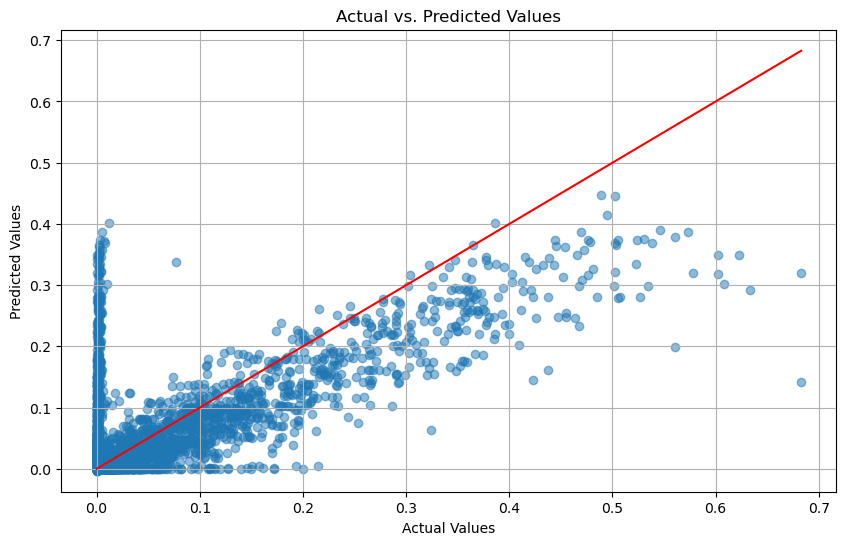

In [30]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')  # a line x=y for reference
plt.show()
